<a href="https://colab.research.google.com/github/ankramirez/ankramirez/blob/main/NYC_taxi_trip_duration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project - Predictive Analytics: New York City Taxi Ride Duration Prediction**

---------------

## **Context**
---------------

New York City taxi rides form the core of the traffic in the city of New York. The many rides taken every day by New Yorkers in the busy city can give us a great idea of traffic times, road blockages, and so on. A typical taxi company faces a common problem of efficiently assigning the cabs to passengers so that the service is hassle-free. One of the main issues is predicting the duration of the current ride so it can predict when the cab will be free for the next trip. Here the data set contains various information regarding the taxi trips, its duration in New York City. We will apply different techniques here to get insights into the data and determine how different variables are dependent on the Trip Duration.

-----------------
## **Objective**
-----------------

- To Build a predictive model, for predicting the duration for the taxi ride. 
- Use Automated feature engineering to create new features

-----------------
## **Dataset**
-----------------

The ``trips`` table has the following fields
* ``id`` which uniquely identifies the trip
* ``vendor_id`` is the taxi cab company - in our case study we have data from three different cab companies
* ``pickup_datetime`` the time stamp for pickup
* ``dropoff_datetime`` the time stamp for drop-off
* ``passenger_count`` the number of passengers for the trip
* ``trip_distance`` total distance of the trip in miles 
* ``pickup_longitude`` the longitude for pickup
* ``pickup_latitude`` the latitude for pickup
* ``dropoff_longitude``the longitude of dropoff 
* ``dropoff_latitude`` the latitude of dropoff
* ``payment_type`` a numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided
* ``trip_duration`` this is the duration we would like to predict using other fields 
* ``pickup_neighborhood`` a one or two letter id of the neighborhood where the trip started
* ``dropoff_neighborhood`` a one or two letter id of the neighborhood where the trip ended


#### **We will do the following steps:**
  * Install the dependencies
  * Load the data as pandas dataframe
  * Perform EDA on the dataset
  * Build features with Deep Feature Synthesis using the [featuretools](https://featuretools.com) package. We will start with simple features and incrementally improve the feature definitions and examine the accuracy of the system

****Uncomment the following code and run it to install the featuretools library****

In [1]:
# Uncomment the code given below, and run the line of code to install featuretools library

!pip install featuretools==0.27.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 327 kB 9.0 MB/s 
     |████████████████████████████████| 281 kB 71.1 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


**Note:** If **!pip install featuretools** doesn't work, please install using the **anaconda prompt** by typing the following command in anaconda prompt
> `conda install -c conda-forge featuretools==0.27.0`




## Importing the necessary libraries

In [2]:
# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                          

# Featauretools for feature engineering
import featuretools as ft

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor, to make prediction
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings("ignore")

print(ft.__version__)
%load_ext autoreload
%autoreload 2

0.27.0


In [3]:
# Set global random seed
np.random.seed(40)

# To preview first five rows. 
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]

# To compute features using automated feature engineering. 
def compute_features(features, cutoff_time):
    # Shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix


# To generate train and test dataset
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows-head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test,y_test)



# To see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=5):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

### Loading the datasets

In [4]:
# If you are using Google Colab then while reading the files using 'pd.read_csv()', replace the location of CSV files with the exact location of the files in your drive folder. 
trips = pd.read_csv('trips.csv',
                        parse_dates=["pickup_datetime","dropoff_datetime"],
                        dtype={'vendor_id':"category",'passenger_count':'int64'},
                        encoding='utf-8')
trips["payment_type"] = trips["payment_type"].apply(str)
trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

pickup_neighborhoods = pd.read_csv("pickup_neighborhoods.csv", encoding='utf-8')
dropoff_neighborhoods = pd.read_csv("dropoff_neighborhoods.csv", encoding='utf-8')

### Viewing the Datasets

In [5]:
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2.0,372.0,AH,C
82981,86651,2,2016-01-17 08:01:20,2016-01-17 08:30:34,1,19.41,-73.788834,40.641750,-73.993362,40.726292,2.0,1754.0,G,H
82980,86650,1,2016-01-17 08:01:17,2016-01-17 08:05:45,1,0.60,-73.981834,40.736660,-73.983353,40.743809,1.0,268.0,R,AO
82979,86649,1,2016-01-17 08:00:56,2016-01-17 08:07:48,1,1.50,-73.954895,40.780186,-73.979858,40.790516,1.0,412.0,C,I
82978,86648,1,2016-01-17 07:58:47,2016-01-17 08:05:07,1,1.40,-73.982056,40.763332,-74.000656,40.757824,1.0,380.0,AR,P
82977,86647,2,2016-01-17 07:57:01,2016-01-17 08:03:39,1,1.78,-73.994873,40.745224,-73.985085,40.728077,2.0,398.0,AP,AT
82976,86646,2,2016-01-17 07:56:51,2016-01-17 07:59:50,6,0.75,-73.938873,40.791397,-73.947617,40.790466,2.0,179.0,J,C
82975,86645,2,2016-01-17 07:56:30,2016-01-17 08:09:20,5,3.45,-73.957481,40.770111,-74.000282,40.758610,1.0,770.0,K,P
82974,86644,2,2016-01-17 07:55:37,2016-01-17 08:06:29,1,3.08,-74.001579,40.727749,-73.971672,40.758041,1.0,652.0,AB,N
82973,86643,1,2016-01-17 07:55:05,2016-01-17 08:00:38,1,2.20,-73.972260,40.786221,-73.993912,40.756691,2.0,333.0,I,P


In [6]:
# Drop the rows where at least one element is missing. 
trips=trips.dropna()

For the features used in the model the "**dropoff_datetime**" needs to be removed as this value would not be known for real-time prediction and you can basically take the difference between the pickup and dropoff time to find the duration.So, this will restrict our model to be **robust** and **reliable**. So, dropping this feature will help us to avoid **data leakage**.

Data leakage in machine learning occurs when the data used to train a machine learning algorithm contains information that the model is attempting to predict, resulting in unreliable and poor prediction outcomes after model deployment.

In [7]:
trips.drop("dropoff_datetime", axis=1, inplace=True) 

### Checking the first five rows of the data

In [8]:
trips.head()

,id,vendor_id,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2.0,372.0,AH,C
1,1,2,2016-01-01 00:01:45,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1.0,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2.0,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2.0,858.0,AT,J
4,4,1,2016-01-01 00:02:49,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1.0,1076.0,AG,AV


**Info** of the data

In [9]:
# Checking the info of the dataset
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124462 entries, 0 to 124461
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    124462 non-null  int64         
 1   vendor_id             124462 non-null  category      
 2   pickup_datetime       124462 non-null  datetime64[ns]
 3   passenger_count       124462 non-null  int64         
 4   trip_distance         124462 non-null  float64       
 5   pickup_longitude      124462 non-null  float64       
 6   pickup_latitude       124462 non-null  float64       
 7   dropoff_longitude     124462 non-null  float64       
 8   dropoff_latitude      124462 non-null  float64       
 9   payment_type          124462 non-null  object        
 10  trip_duration         124462 non-null  float64       
 11  pickup_neighborhood   124462 non-null  object        
 12  dropoff_neighborhood  124462 non-null  object        
dtyp

- There are 974409 non null values in the dataset

### **Checking the number of unique values in the dataset**

In [10]:
# Check the uniques values in each columns
trips.nunique()

id                      124462
vendor_id                    2
pickup_datetime         120224
passenger_count              7
trip_distance             2090
pickup_longitude         12958
pickup_latitude          26513
dropoff_longitude        15454
dropoff_latitude         30868
payment_type                 4
trip_duration             3367
pickup_neighborhood         49
dropoff_neighborhood        49
dtype: int64

- vendor_id has only 2 unique values, implies there are only 2 major taxi vendors are there. 
- Passenger count has 8 unique values and payment type have 4. 
- There are 49 neighborhood in the dataset, from where either a pickup or dropoff is happening. 

### Summary statistics of the dataset

In [11]:
# Checking the descriptive stats of the data

trips.describe().T

,count,mean,std,min,25%,50%,75%,max
id,124462.0,64916.735461,37536.416253,0.000000,32379.250000,64945.500000,97365.750000,129959.000000
passenger_count,124462.0,1.677845,1.330972,0.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,124462.0,2.701010,3.261636,0.000000,0.990000,1.600000,2.900000,32.300000
pickup_longitude,124462.0,-73.972617,0.036726,-74.029053,-73.990799,-73.980980,-73.966408,-73.770927
pickup_latitude,124462.0,40.752386,0.026931,40.631462,40.739826,40.755617,40.769001,40.849884
dropoff_longitude,124462.0,-73.972834,0.031038,-74.029625,-73.990158,-73.979080,-73.962753,-73.770020
dropoff_latitude,124462.0,40.753197,0.028812,40.630047,40.739136,40.755850,40.770481,40.849937
trip_duration,124462.0,743.926074,541.531157,0.000000,367.000000,601.000000,958.000000,3605.000000


- The summary of the id variable is provided since it is a numerical varibale, but is senseless.
- The trip_distance seems to be somehow normal-distributed according to Q1, Q2, and Q3 values, but the maximum value denotes the presence of outliers.
- Also, the lowest value is 0, which doesn't make much sense to take a trip without the intention of displace oneself.
- According to Q1, Q2, and Q3 values of pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, and also STD, all variables seem to be scarcely sparce. All trips seem to be bounded around around this region.
- The trip_duration variable has a wide range, and the presence of outliers is confirmed by the calculation of the IQR=651, providing a range of [0,2016.5]. Furthermore, the presence of trips of duration 0 doesn't make much sense, unless the cancelled trips are being considered.

### **Checking for the rows for which trip_distance is 0**

In [12]:
# Chekcing the rows where trip distance is 0
trips[trips['trip_distance']==0]

,id,vendor_id,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
852,880,1,2016-01-01 02:15:56,1,0.0,-74.002586,40.750298,-74.002861,40.750446,2.0,21.0,AG,AG
1079,1116,1,2016-01-01 03:01:10,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3.0,136.0,H,H
1408,1455,2,2016-01-01 04:09:43,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2.0,65.0,AR,AR
1440,1488,1,2016-01-01 04:16:54,1,0.0,-74.014198,40.709988,-74.014198,40.709988,3.0,3.0,AU,AU
1510,1558,1,2016-01-01 04:36:03,1,0.0,-73.952507,40.817329,-73.952499,40.817322,2.0,13.0,AL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123906,129387,1,2016-01-26 15:37:23,2,0.0,-73.782417,40.648815,-73.782394,40.648834,2.0,19.0,G,G
124091,129577,2,2016-01-26 16:34:06,1,0.0,-73.794685,40.667576,-73.794556,40.667515,4.0,99.0,G,G
124168,129654,2,2016-01-26 16:56:25,1,0.0,-73.783058,40.643856,-73.783081,40.643902,1.0,83.0,G,G
124422,129918,1,2016-01-26 18:00:56,1,0.0,-73.979179,40.784992,-73.979195,40.785004,3.0,4.0,I,I


- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 
- There are 3807 such rows

#### **Replacing the 0 values with median of the trip distance**

In [13]:
trips['trip_distance']=trips['trip_distance'].replace(0,trips['trip_distance'].median())

In [14]:
trips[trips['trip_distance']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

#### **Checking for the rows for which trip_duration is 0**

In [15]:
trips[trips['trip_duration']==0].head()

,id,vendor_id,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
44446,46325,1,2016-01-10 00:48:55,1,1.20,-73.968842,40.766972,-73.968842,40.766972,3.0,0.0,AK,AK
121544,126869,2,2016-01-26 00:07:47,6,4.35,-73.986694,40.739815,-73.956139,40.732872,1.0,0.0,R,Z


- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values. 

In [16]:
trips['trip_duration']=trips['trip_duration'].replace(0,trips['trip_duration'].median())

In [17]:
trips[trips['trip_duration']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

## **Univariate Analysis**

### Building histograms for numerical columns

In [18]:
num_trips = trips.drop(columns=['id','pickup_datetime','pickup_neighborhood','dropoff_neighborhood'])

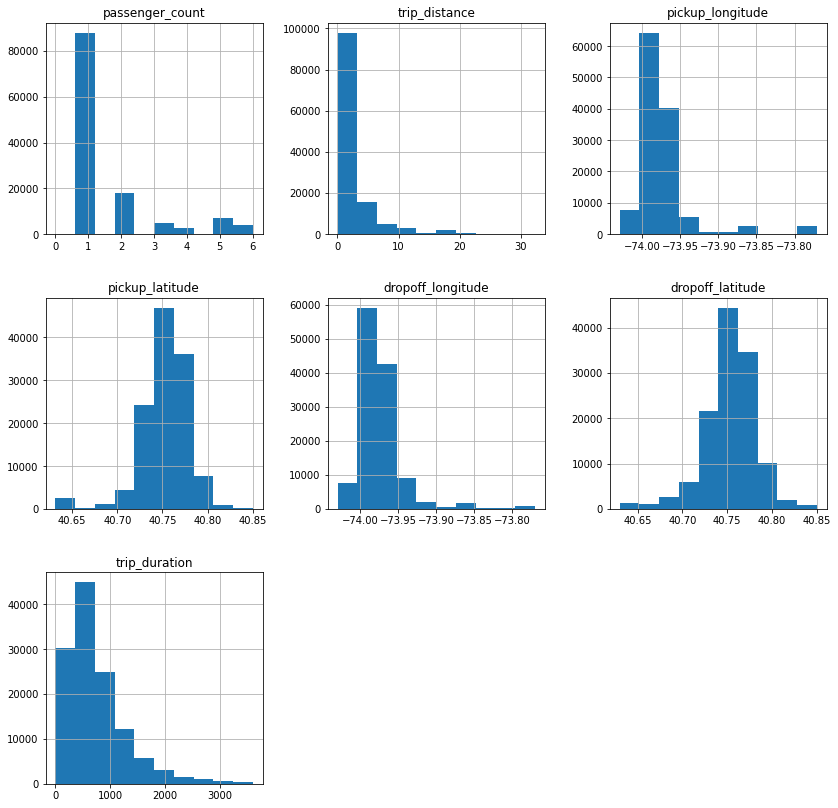

In [19]:
num_trips.hist(figsize=(14,14))
plt.show()

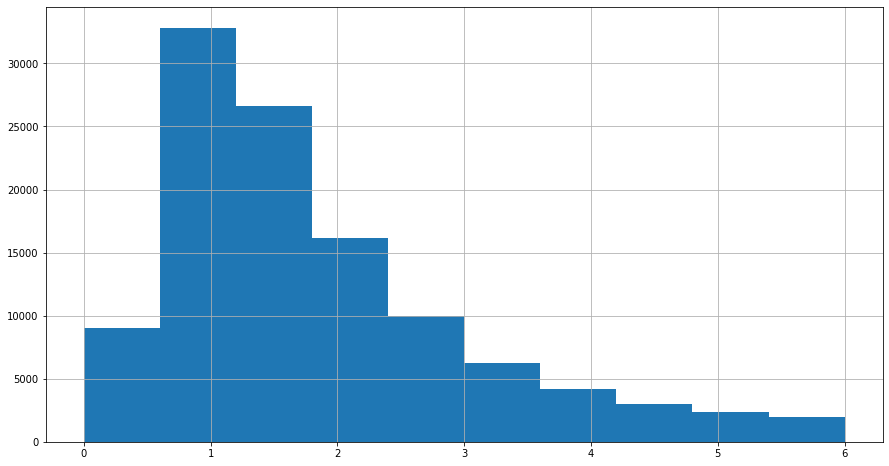

In [20]:
trips['trip_distance'].hist(range=(0,6), figsize=(15,8))
plt.show()

Using the definition of IQR to define outliers in the trip_distance variable, we use a range of [0,6] (Q1 = 1, Q3=3, IQR = 2, Q2)<br>
lower bound = 1 - 1.5x2 = -2 (we use zero as negative quantities don't make sense.)<br>
upper bound = 3 + 1.5x2 = 6 

- The passenger_count is a right-skewed distribution, seem to have a median and mode value for 1, and it's not so wide-spread distributed.
- The trip_distance is analyzed previously, where the distribution can be studied more clearly; it is right-skewed, and the median seems to sit somewhere around 1.5.
- As discussed before, the variables pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, are closely distributed, with no skewness for longitude, but it's right-skewed for longitude, and the locations associated to these coordinates correspond to airport-hotel's area in NYC, which make sense. There are a lot of pick-ups and drop-offs from the hotel-area.
- The mean duration time is 797, which divided by 60, gives 13.28 which I assume are minutes, this time is coherent with the commuting time between airport-hotel area, which is around 15 minutes.

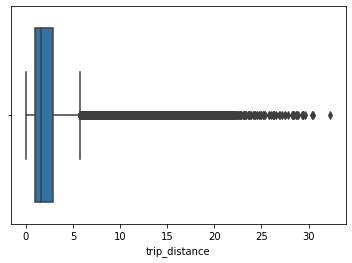

In [21]:
sns.boxplot(trips['trip_distance'])
plt.show()

There is an extreme outlier in the dataset, which shall be dropped

In [22]:
trips[trips['trip_distance']>100]

,id,vendor_id,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood


- We can observe that, there are 2 observation>500, and there is a huge gap in the trip duration for them.
- Covering 501.4 distance in 141 sec, is not possible, it is better we can clip these values to 50. 

**Clipping the outliers of trip distance to 50**

In [23]:
trips['trip_distance']=trips['trip_distance'].clip(trips['trip_distance'].min(),50)

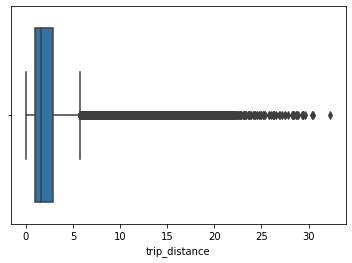

In [24]:
sns.boxplot(trips['trip_distance'])
plt.show()

### Plotting countplot for Passenger_count

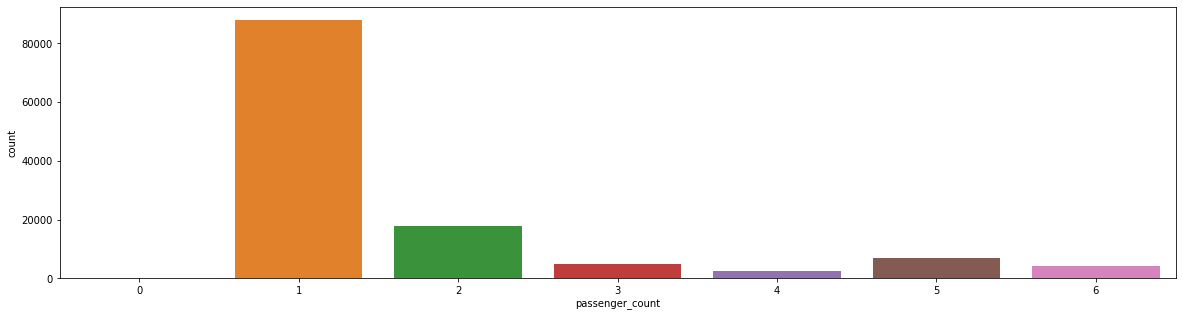

In [25]:
plt.figure(figsize=(20,5))
sns.countplot(trips['passenger_count'])
plt.show()

In [26]:
trips.passenger_count.value_counts(normalize=True)

1    0.706593
2    0.143048
5    0.056363
3    0.040229
6    0.033842
4    0.019902
0    0.000024
Name: passenger_count, dtype: float64

- The central values will most likely be around the value of 1.
- The are other values of 5, 6, and 9, which seem strange values for a taxi trip. It would be interesnting to verify if the other variables of the data of this amount of passengers are alike with those variables for the trips for 4 and less persons.
- There is a small percentage of trips with 0 passengers, wich seems an odd value, it should be investigated.

In [27]:
passengermore5 = trips[trips['passenger_count']>=5]
passengerless4 = trips[trips['passenger_count']<=4]
passengermore5=passengermore5.drop(columns=['id', 'pickup_datetime','passenger_count'])
passengerless4=passengerless4.drop(columns=['id', 'pickup_datetime','passenger_count'])

In [28]:
print('DATA FOR PASSENGERS COUNT 5 OR MORE')
passengermore5.describe().T

DATA FOR PASSENGERS COUNT 5 OR MORE


,count,mean,std,min,25%,50%,75%,max
trip_distance,11227.0,2.795929,3.378092,0.010000,1.000000,1.650000,2.920000,28.400000
pickup_longitude,11227.0,-73.971787,0.037935,-74.021393,-73.990719,-73.980644,-73.965717,-73.776375
pickup_latitude,11227.0,40.752574,0.027248,40.635792,40.740135,40.755962,40.769606,40.846180
dropoff_longitude,11227.0,-73.972512,0.031314,-74.023621,-73.990002,-73.978912,-73.962330,-73.770943
dropoff_latitude,11227.0,40.753126,0.028906,40.631924,40.739391,40.755783,40.770599,40.848679
trip_duration,11227.0,753.846174,546.614564,2.000000,371.500000,611.000000,970.000000,3597.000000


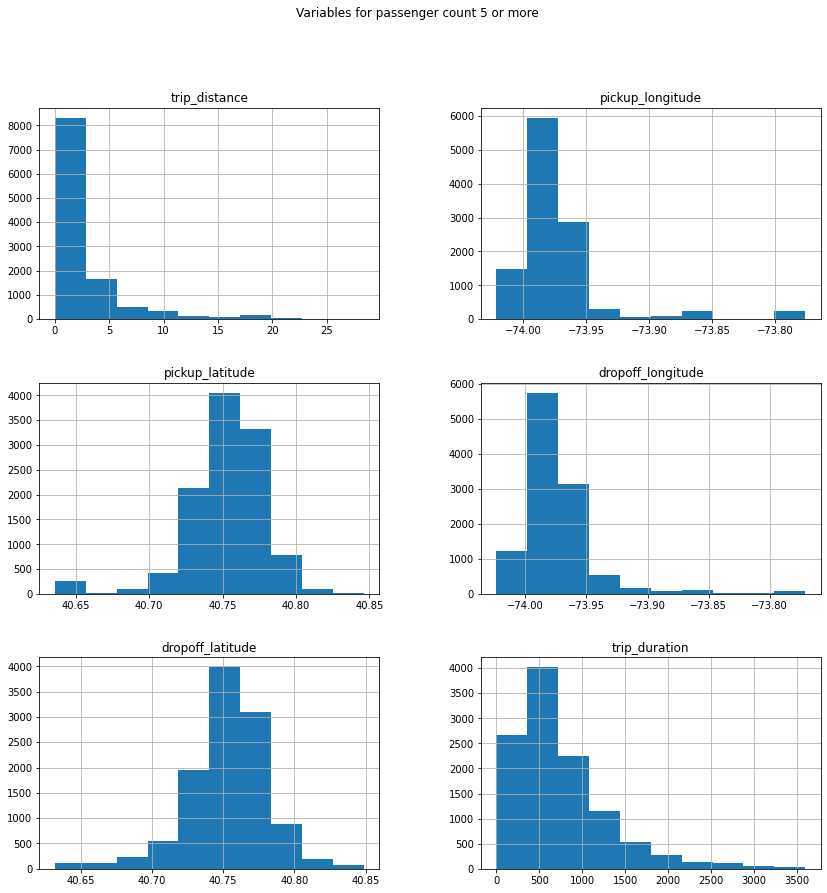

In [29]:
passengermore5.hist(figsize=(14,14))
plt.suptitle('Variables for passenger count 5 or more')
plt.show()

In [30]:
print('DATA FOR PASSENGERS COUNT 4 OR LESS')
passengerless4.describe().T

DATA FOR PASSENGERS COUNT 4 OR LESS


,count,mean,std,min,25%,50%,75%,max
trip_distance,113235.0,2.697971,3.246009,0.010000,1.000000,1.600000,2.890000,32.300000
pickup_longitude,113235.0,-73.972699,0.036603,-74.029053,-73.990807,-73.981010,-73.966480,-73.770927
pickup_latitude,113235.0,40.752368,0.026900,40.631462,40.739792,40.755585,40.768948,40.849884
dropoff_longitude,113235.0,-73.972866,0.031010,-74.029625,-73.990166,-73.979111,-73.962807,-73.770020
dropoff_latitude,113235.0,40.753204,0.028803,40.630047,40.739094,40.755859,40.770470,40.849937
trip_duration,113235.0,742.953133,541.008387,1.000000,367.000000,600.000000,957.000000,3605.000000


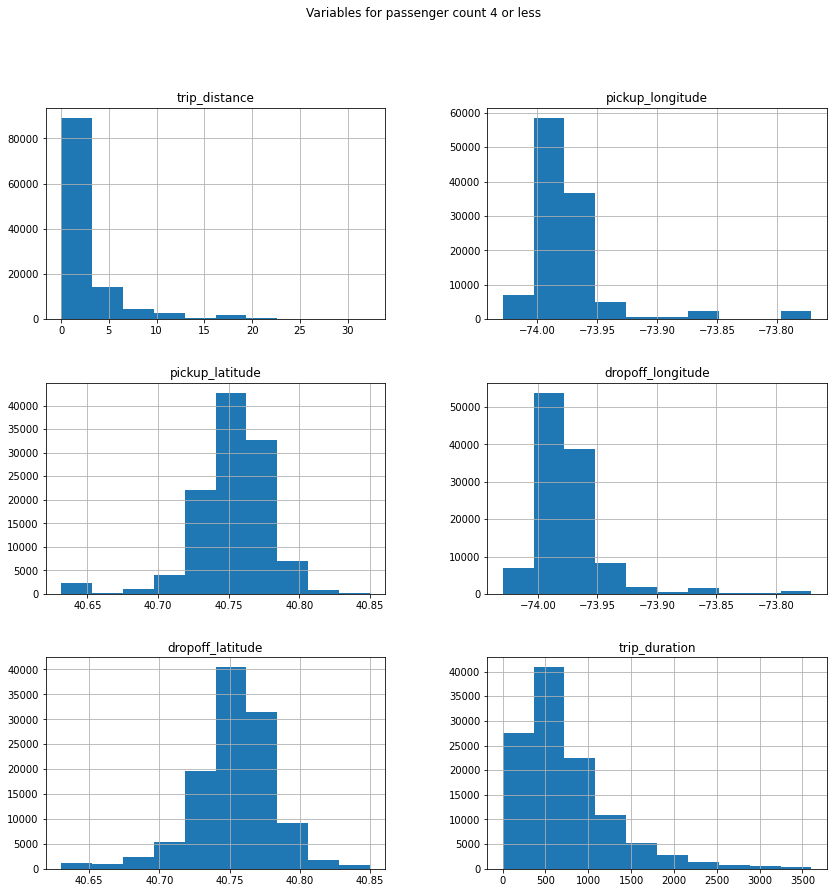

In [31]:
passengerless4.hist(figsize=(14,14))
plt.suptitle('Variables for passenger count 4 or less')
plt.show()

- The total trips of 5 passengers or more amounts almost a 9% of the total trips.
- For the DISTANCE, in the case of the trips of the passenger count of 5 passengers or more, the average distance seems to be a bit larger, while the count of 4 passengers or less have outliers of greater value.
- The longitude and latitude for pickup and dropoff locations doesn't seem to change much.
- The DURATION for the trips of 5 passengers or more seems slightly longer in average and in general for Q1, Q2, and Q3, whereas the maximum duration value stays around the same.

### Plotting countplot for pickup_neighborhood and dropoff_neighborhood

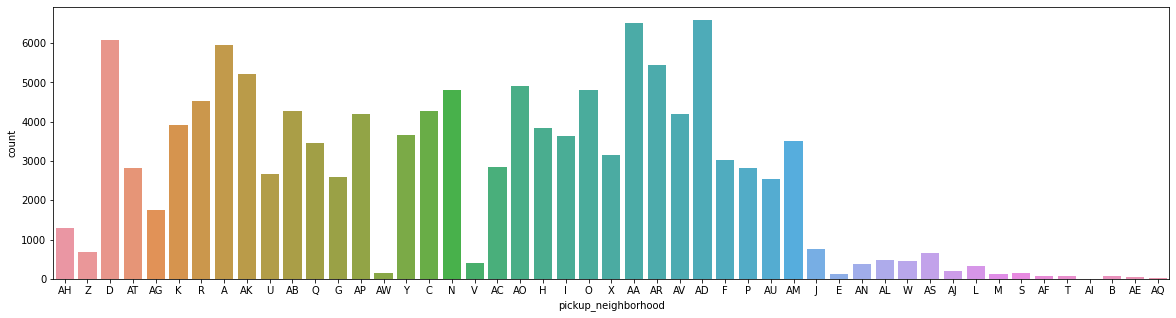

In [32]:
plt.figure(figsize=(20,5))
sns.countplot(trips['pickup_neighborhood'])
plt.show()

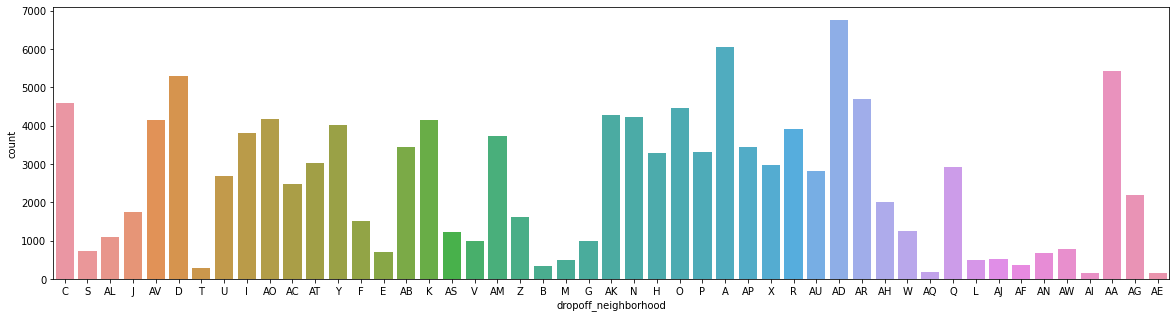

In [33]:
plt.figure(figsize=(20,5))
sns.countplot(trips['dropoff_neighborhood'])
plt.show()

- It can be seen that there are some places where there are not so many pick-ups but there are an important amount of drop-off. Knowing this information is important for the drivers, as they would like to know if they could expect to have a pick-up after a drop-off. 
- An analysis of the neighborhoods as function of the time would be valuable as well, in order for the driver to go to a neighborhood where he's likely to pick-up a client at a specific time, and avoid certain neighborhoods at certain hours, where there's probably no clients to pick-up.
- The previous analysis could be also extended to an aggregated primitive for the time and day of the week.


## **Bivariate analysis**

#### **Plot a scatter plot for trip distance and trip duration**

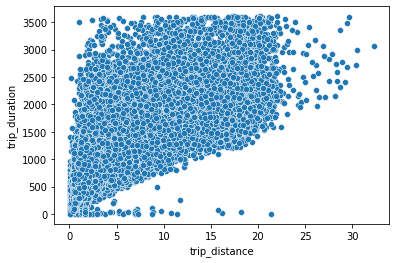

In [34]:
sns.scatterplot(trips['trip_distance'],trips['trip_duration'])

- There is some positive correlation between trip_distance and trip_duration.

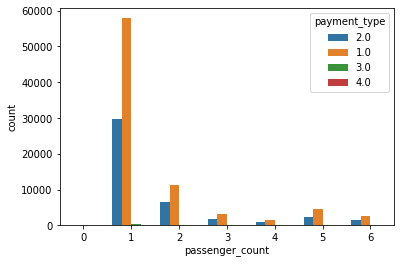

In [35]:
sns.countplot(trips['passenger_count'],hue=trips['payment_type'])

- There is no such specific pattern can be observed.

## **Preparing the Data**

Lets create entities and relationships. The three entities in this data are 
* trips 
* pickup_neighborhoods
* dropoff_neighborhoods

This data has the following relationships
* pickup_neighborhoods --> trips (one neighborhood can have multiple trips that start in it. This means pickup_neighborhoods is the ``parent_entity`` and trips is the child entity)
* dropoff_neighborhoods --> trips (one neighborhood can have multiple trips that end in it. This means dropoff_neighborhoods is the ``parent_entity`` and trips is the child entity)

In [featuretools](https://featuretools.alteryx.com/en/v0.27.0/getting_started/getting_started_index.html) (automated feature engineering software package), we specify the list of entities and relationships as follows: 


### Defining entities and relationships for the Deep Feature Synthesis

In [36]:
entities = { 
    'trips':(trips,'id','pickup_datetime'),
    'pickup_neighborhoods': (pickup_neighborhoods,'neighborhood_id'),
    'dropoff_neighborhoods': (dropoff_neighborhoods, 'neighborhood_id'),
}

relationships = [('pickup_neighborhoods','neighborhood_id','trips','pickup_neighborhood'),
                 ('dropoff_neighborhoods','neighborhood_id','trips','dropoff_neighborhood')]

Next, we specify the cutoff time for each instance of the target_entity, in this case ``trips``.This timestamp represents the last time data can be used for calculating features by DFS. In this scenario, that would be the pickup time because we would like to make the duration prediction using data before the trip starts. 

For the purposes of the case study, we choose to only select trips that started after **January 12th, 2016**. 

In [37]:
cutoff_time = trips[['id', 'pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['pickup_datetime'] > "2016-01-12"]
preview(cutoff_time, 10)

,id,pickup_datetime
54031,56311,2016-01-12 00:00:25
100975,105349,2016-01-20 18:38:31
100976,105350,2016-01-20 18:38:51
100977,105351,2016-01-20 18:38:54
100978,105352,2016-01-20 18:39:07
100979,105353,2016-01-20 18:39:14
100980,105354,2016-01-20 18:39:23
100981,105355,2016-01-20 18:39:29
100982,105356,2016-01-20 18:39:34
100983,105357,2016-01-20 18:39:34


## **Step 3: Creating baseline features using Deep Feature Synthesis**

Instead of manually creating features, such as "month of pickup datetime", we can let DFS come up with them automatically. It does this by 
* interpreting the variable types of the columns e.g categorical, numeric and others 
* matching the columns to the primitives that can be applied to their variable types
* creating features based on these matches

**Create transform features using transform primitives**

As we described in the video, features fall into two major categories, ``transform`` and ``aggregate``. In featuretools, we can create transform features by specifying ``transform`` primitives. Below we specify a ``transform`` primitive called ``weekend`` and here is what it does:

* It can be applied to any ``datetime`` column in the data. 
* For each entry in the column, it assess if it is a ``weekend`` and returns a boolean. 

In this specific data, there are two ``datetime`` columns ``pickup_datetime`` and ``dropoff_datetime``. The tool automatically creates features using the primitive and these two columns as shown below. 

## Creating a baseline model with only 1 transform primitive

### Defining transform primitive for weekend and define features using dfs 

In [38]:
trans_primitives = [IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

Here are the features created.

In [39]:
print ("Number of features: %d" % len(features))
features

Number of features: 12


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]


Now let's compute the features. 

### Computing features and defining feature matrix

In [40]:
def compute_features(features, cutoff_time):
    # Shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

In [41]:
feature_matrix1 = compute_features(features, cutoff_time)

Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


In [42]:
preview(feature_matrix1, 5)

,passenger_count,pickup_neighborhood = AD,pickup_neighborhood = AA,pickup_neighborhood = A,pickup_neighborhood = D,pickup_neighborhood = AR,pickup_neighborhood = AK,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,...,dropoff_neighborhood = AK,dropoff_neighborhood = N,dropoff_neighborhood = K,pickup_neighborhoods.longitude,IS_WEEKEND(pickup_datetime),trip_distance,trip_duration,dropoff_neighborhoods.latitude,pickup_neighborhoods.latitude,vendor_id
id,,,,,,,,,,,,,,,,,,,,,
56311,1,False,False,False,False,False,False,False,False,False,...,False,False,False,-73.987205,False,1.61,645.0,40.721435,40.720245,2
105349,1,False,False,True,False,False,False,False,False,False,...,False,True,False,-73.975899,False,0.60,349.0,40.756598,40.761492,1
105350,2,False,False,False,False,False,False,True,False,False,...,False,False,False,-73.985336,False,1.10,942.0,40.750179,40.747126,1
105351,1,False,False,False,False,False,False,False,False,False,...,False,False,False,-73.995736,False,1.30,845.0,40.761492,40.761087,1
105352,4,False,False,False,False,False,False,False,False,False,...,False,False,False,-73.982322,False,1.35,366.0,40.793597,40.776270,2


In [43]:
feature_matrix1.shape

(70431, 30)

### **Model Building**
------------------

To build a model, we
* Separate the data into a portion for ``training`` (75% in this case) and a portion for ``testing`` 
* Get the log of the trip duration so that a more linear relationship can be found.
* Train a model using a ``Linear Regression, Decision Tree and Random Forest model``

#### **Transforming the duration variable on sqrt and log**



(array([  543.,  4979., 23195., 34064., 28913., 17425.,  8675.,  4003.,
         1802.,   863.]),
 array([ 1.        ,  6.90416522, 12.80833044, 18.71249566, 24.61666088,
        30.5208261 , 36.42499133, 42.32915655, 48.23332177, 54.13748699,
        60.04165221]),
 <a list of 10 Patch objects>)

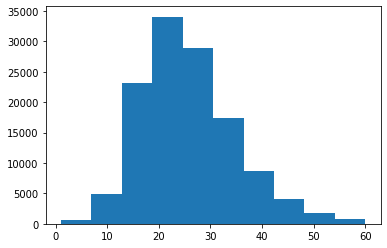

In [44]:
plt.hist(np.sqrt(trips['trip_duration']))

(array([3.2000e+01, 6.9000e+01, 7.2000e+01, 1.7800e+02, 3.5300e+02,
        2.7720e+03, 1.9225e+04, 5.0476e+04, 4.1785e+04, 9.5000e+03]),
 array([0.        , 0.8190077 , 1.63801541, 2.45702311, 3.27603082,
        4.09503852, 4.91404623, 5.73305393, 6.55206164, 7.37106934,
        8.19007705]),
 <a list of 10 Patch objects>)

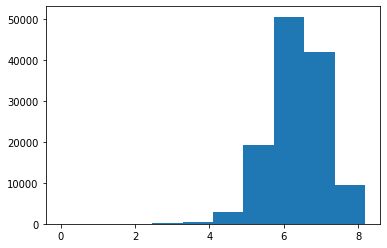

In [45]:
plt.hist(np.log(trips['trip_duration']))

- We can clearly see that the sqrt transformation is giving nearly normal distribution, therefore we can choose the sqrt transformation on the dependent(trip_duration) variable.

#### **Splitting the data into train and test**

In [46]:
# Separates the whole feature matrix into train data feature matrix, train data labels, and test data feature matrix 
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1,.75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

**Defining function for to check the performance of the model.**

In [47]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))

# Model Performance on test and train data
def model_pref(model, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                'RSquared':
                    [r2_score(y_observed_train,y_pred_train),
                    r2_score(y_observed_test,y_pred_test )
                    ],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
            }
        )
    )

### Building Linear regression using only weekend transform primitive

In [48]:
# Defining the model
lr1=LinearRegression()

# Fitting the model
lr1.fit(X_train,y_train)


LinearRegression()

#### **Checking the performance of the model**

In [49]:
model_pref(lr1, X_train, X_test,y_train,y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.590797  5.802519  4.500993
1   Test  0.472967  7.148916  5.338872


- RSquared for the test data is 0.55, RSME = 6.55, and MAE = 4.17; these values are not so different that those obtained for the train data. The model performs slightly better on the train data.
- The model doesn't seem to be overfitting, but in any case it's not performing as well as desired.

### Building decision tree using only weekend transform primitive

In [50]:
# Define the model
dt=DecisionTreeRegressor()

# Fit the model
dt.fit(X_train,y_train)

DecisionTreeRegressor()

#### **Check the performance of the model**

In [51]:
model_pref(dt, X_train, X_test,y_train,y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.972363  1.507969  0.554785
1   Test  0.497729  6.978950  5.183201


- Since the model performance is much better in the train data compared to the test data, it can be inferred that it's overfitting the train data.
- The performance can be improved by 'pruning' some of the branches of the model, which is done by defining a maximum depth for the model.


### Building Pruned decision tree using only weekend transform primitive

In [52]:
# Define the model

# Use max_depth=7
dt_pruned=DecisionTreeRegressor(max_depth=7)

# Fit the model
dt_pruned.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=7)

#### **Checking the performance of the model**

In [53]:
model_pref(dt_pruned, X_train,X_test,y_train,y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.743405  4.594846  3.504844
1   Test  0.636437  5.937601  4.261875


- The pruned model is performing worse in the train data than the non-pruned one on the train data, but it performs much better on the test data than the non-pruned data. 
- The pruned model doesn't overfit the data as much as the non-pruned model. 


### **Building Random Forest using only weekend transform primitive**

In [54]:
# Define the model

# using (n_estimators=60,max_depth=7)
rf=RandomForestRegressor(n_estimators=60,max_depth=7)

In [55]:
# Fit the model
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### **Checking the performance of the model**

In [56]:
model_pref(rf,X_train,X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.752032  4.516946  3.449458
1   Test  0.646628  5.853793  4.192629


- The values for the test data are RSquared = 0.708, RMSE = 5.314, MAE = 4.019. 
- The random forest model seems to perform better than any other of the other models, however, the interpretability is not as clear as for the linear model for example.


### **Step 4: Adding more Transform Primitives and creating new model**

* Add ``Minute``, ``Hour``, ``Month``, ``Weekday`` , etc primitives
* All these transform primitives apply to ``datetime`` columns

## **Creating models with more transform primitives**



### **Defining more transform primitives and define features using dfs**

In [57]:
trans_primitives = [Minute,Hour,Month,Weekday,IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [58]:
print ("Number of features: %d" % len(features))
features

Number of features: 16


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Now let's compute the features. 

### **Computing features and defining feature matrix**

In [59]:
feature_matrix2 = compute_features(features,cutoff_time)

Elapsed: 00:01 | Progress: 100%|██████████
Finishing computing...


In [60]:
feature_matrix2.shape

(70431, 34)

In [61]:
feature_matrix2.head()

,MINUTE(pickup_datetime),pickup_neighborhoods.longitude,passenger_count,IS_WEEKEND(pickup_datetime),pickup_neighborhoods.latitude,HOUR(pickup_datetime),trip_duration,dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,...,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = O,pickup_neighborhood = R,dropoff_neighborhoods.latitude,vendor_id,MONTH(pickup_datetime),dropoff_neighborhoods.longitude,WEEKDAY(pickup_datetime),trip_distance
id,,,,,,,,,,,,,,,,,,,,,
56311,0,-73.987205,1,False,40.720245,0,645.0,False,False,False,...,False,False,False,False,40.721435,2,1,-73.998366,1,1.61
56312,2,-73.785073,1,False,40.646194,0,1270.0,False,False,False,...,False,False,False,False,40.715828,2,1,-73.954298,1,16.15
56313,2,-73.948046,1,False,40.818445,0,207.0,False,False,False,...,False,False,False,False,40.818445,1,1,-73.948046,1,0.80
56314,2,-73.991595,5,False,40.729652,0,214.0,False,False,False,...,False,False,False,False,40.742531,2,1,-73.977943,1,1.33
56315,3,-73.969822,1,False,40.793597,0,570.0,False,False,False,...,False,False,False,False,40.818445,2,1,-73.948046,1,2.35


**Building the new models with more transform features**

In [62]:
# Separates the whole feature matrix into train data feature matrix,train data labels, and test data feature matrix 
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2,.75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

### **Building Linear regression using more transform primitives**

In [63]:
# Defining the model
lr2=LinearRegression()

# Fitting the model
lr2.fit(X_train2,y_train2)

LinearRegression()

#### **Checking the performance of the model**

In [64]:
model_pref(lr2,X_train2,X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.594388  5.777000  4.473694
1   Test  0.451723  7.291571  5.437491


- The performance of the linear model after adding more transform primitives is slightly better. 
- However, the performance is altogether poor.

### **Building Decision tree using more transform primitives**

In [65]:
# Define the model
dt2=DecisionTreeRegressor()
# Fit the model
dt2.fit(X_train2,y_train2)


DecisionTreeRegressor()

#### **Checking the performance of the model**

In [66]:
model_pref(dt2,X_train2,X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.999996  0.018133  0.000135
1   Test  0.550742  6.600379  4.852770


- The decision tree after adding more transform primitives is overfitting the data, as it can be inferred from the over all low RMSE, MAE and great value of RSquared for the train data and poor evaluation parameters when evaluated for the test data.
- It's required to 'prun' the model in order to get rid of the overfitting and improve the performance.

### **Building Pruned Decision tree using more transform primitives**

In [67]:
# Define the model

# Use max_depth=7
dt_pruned2=DecisionTreeRegressor(max_depth=7)

# Fit the model
dt_pruned2.fit(X_train2,y_train2)

DecisionTreeRegressor(max_depth=7)

#### **Checking the performance of the model**

In [68]:
model_pref(dt_pruned2,X_train2,X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.782273  4.232559  3.173260
1   Test  0.666536  5.686505  4.045782


- The decision tree model with a maximum depth of 7 performs better after adding more transform primitives.
- This model performs better than a linear regression.



### **Building Random Forest using more transform primitives**

In [69]:
# Fit the model
# Using (n_estimators=60,max_depth=7)

rf2=RandomForestRegressor(n_estimators=60,max_depth=7)

# Fit the model

rf2.fit(X_train2,y_train2)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### **Checking the performance of the model**

In [70]:
model_pref(rf2, X_train2,X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.794009  4.116908  3.074102
1   Test  0.674576  5.617535  3.970695


- The random forest model after adding transform primitives perform considerably better.


### **How the modeling accuracy differs when including more transform features?**

- All three models: Linear, Decision Tree and Random Forest perform considerably better after adding transform primitives corresponding to Minute, Hour, Month and Weekday applied to the datetime column.

- The Random Forest model, as usual, peforms considerably better than the other two models however, the interpretability of such models is not as easy to understand.

### **Step 5: Add Aggregation Primitives**

Now let's add aggregation primitives. These primitives will generate features for the parent entities ``pickup_neighborhoods``, and ``dropoff_neighborhood`` and then add them to the trips entity, which is the entity for which we are trying to make prediction.

## **Creating models with transform and aggregate primitives.**


### **Defining more transform and aggregate primitives and defining features using dfs**

In [71]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [72]:
print ("Number of features: %d" % len(features))
features

Number of features: 55


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_duration)>,
 <Feature: pickup_neighborhoods.MEAN(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MEAN(trips.trip_distance)>,
 <Feature: pickup_neighborhoods.MEAN(trips.trip_duration

### **Computing features and defining feature matrix**

In [73]:
feature_matrix3 = compute_features(features,cutoff_time)

Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


In [74]:
feature_matrix3.head()

,HOUR(pickup_datetime),dropoff_neighborhoods.MEAN(trips.trip_duration),MONTH(pickup_datetime),dropoff_neighborhoods.STD(trips.trip_distance),pickup_neighborhoods.MEAN(trips.trip_distance),pickup_neighborhoods.SUM(trips.passenger_count),IS_WEEKEND(pickup_datetime),pickup_neighborhoods.COUNT(trips),pickup_neighborhoods.SUM(trips.trip_duration),pickup_neighborhoods.MAX(trips.trip_distance),...,dropoff_neighborhoods.STD(trips.passenger_count),dropoff_neighborhoods.MIN(trips.trip_duration),dropoff_neighborhoods.MAX(trips.passenger_count),trip_distance,pickup_neighborhoods.longitude,dropoff_neighborhoods.MEDIAN(trips.trip_duration),dropoff_neighborhoods.MEDIAN(trips.passenger_count),pickup_neighborhoods.MAX(trips.passenger_count),dropoff_neighborhoods.MAX(trips.trip_duration),dropoff_neighborhoods.MAX(trips.trip_distance)
id,,,,,,,,,,,,,,,,,,,,,
56311,0,776.627978,1,2.776681,3.008120,2219,False,1298,965650.0,18.57,...,1.303984,1.0,6,1.61,-73.987205,668.0,1.0,6,3572.0,20.54
56312,0,1036.722148,1,3.831003,15.573704,2239,False,1250,2581191.0,32.30,...,1.335982,4.0,6,16.15,-73.785073,942.0,1.0,6,3526.0,19.00
56313,0,933.914230,1,3.706270,2.867798,390,False,218,146585.0,18.50,...,1.289944,6.0,6,0.80,-73.948046,898.0,1.0,6,3312.0,25.30
56314,0,570.183240,1,2.399307,2.285062,2838,False,1703,1156824.0,18.30,...,1.375904,9.0,6,1.33,-73.991595,474.0,1.0,6,3581.0,19.16
56315,0,933.914230,1,3.706270,2.146973,1897,False,1176,721542.0,20.30,...,1.289944,6.0,6,2.35,-73.969822,898.0,1.0,6,3312.0,25.30


**Building the new models with more transform and aggregate features**

In [75]:
# Separates the whole feature matrix into train data feature matrix,train data labels, and test data feature matrix 
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3,.75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

### **Building Linear regression model with transform and aggregate primitives.**

In [76]:
# Defining the model
lr3=LinearRegression()
# Fitting the model
lr3.fit(X_train3,y_train3)

LinearRegression()

#### **Checking the performance of the model**

In [77]:
model_pref(lr3,X_train3,X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.618912  5.599634  4.313373
1   Test  0.502523  6.945563  5.174276


- The performance of the linear model after adding transform and aggregate primitives is enhanced.
- Pitiably, it's not as good as desired.


### **Building  Decision tree with transform and aggregate primitives**

In [78]:
# Define the model
dt3=DecisionTreeRegressor()

# Fit the model

dt3.fit(X_train3,y_train3)

DecisionTreeRegressor()

#### **Checking the performance of the model**

In [79]:
model_pref(dt3,X_train3,X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.999996  0.017617  0.000108
1   Test  0.549236  6.611431  4.886171


- The Decision Tree Model after adding transforma and aggregate primitives overfit the data if a maximum depth is not set.

### **Building Pruned Decision tree with transform and aggregate primitives.**

In [80]:
# Define the model

# Use max_depth=7
dt_pruned3=DecisionTreeRegressor(max_depth=7)

# Fit the model
dt_pruned3.fit(X_train3,y_train3)

DecisionTreeRegressor(max_depth=7)

#### **Checking the performance of the model**

In [81]:
model_pref(dt_pruned3,X_train3,X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.784331  4.212509  3.157483
1   Test  0.676993  5.596638  4.003587


- The Decision Tree Model 'pruned' (maximum depth=7), after adding transform and aggregate primitives doesn't perform better than that model obtained using transform primitives only, and the computation time increase greatly.

### **Building Random Forest with transform and aggregate primitives**

In [82]:
# Fit the model
# Using (n_estimators=60,max_depth=7)

rf3=RandomForestRegressor(n_estimators=60,max_depth=7)

# Fit the model
rf3.fit(X_train3,y_train3)

RandomForestRegressor(max_depth=7, n_estimators=60)

#### **Checking the performance of the model**

In [83]:
model_pref(rf3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  0.798210  4.074715  3.048134
1   Test  0.691466  5.469812  3.891186


- The Random Forest model after adding transform and aggregate primitives performs just slightly better than that which only includes transform primitives.
- The training time increased considerably, without a major gain.



### **How do these aggregate transforms impact performance? How do they impact training time?**

- The major improvement amongst all three models was seen in the linear model,after adding the aggregate primitives as well as the transform primitives.
- For both Decision Tree and Random Forest, the improvement on the performance is practically negligible, and implies a great deal of time in comparison with the model trained using solely the transform primitives.
- The model that outperform the others in terms of accuracy and computational time is the Random Forest with 60 estimators and depth of 7, when the transform primites are added (Minute,Hour,Month,Weekday,IsWeekend). 

**Based on the above 3 models, we can make predictions using our model2, as it is giving almost same accuracy as model3 and also the training time is not that large as compared to model3**

In [84]:
y_pred = rf2.predict(X_test2)
y_pred = y_pred**2 # Undo the sqrt we took earlier
y_pred[5:]

array([ 712.66843209,  717.97113402,  178.91140974, ...,  400.02401148,
        401.29170272, 2330.06716694])

### **What are some important features based on `model2` and how can they affect the duration of the rides?**

In [85]:
feature_importances(rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=10)

1: Feature: trip_distance, 0.915
2: Feature: HOUR(pickup_datetime), 0.056
3: Feature: dropoff_neighborhoods.latitude, 0.009
4: Feature: WEEKDAY(pickup_datetime), 0.008
5: Feature: IS_WEEKEND(pickup_datetime), 0.003
6: Feature: pickup_neighborhoods.longitude, 0.003
7: Feature: payment_type, 0.002
8: Feature: dropoff_neighborhoods.longitude, 0.002
9: Feature: pickup_neighborhoods.latitude, 0.001
10: Feature: MINUTE(pickup_datetime), 0.000


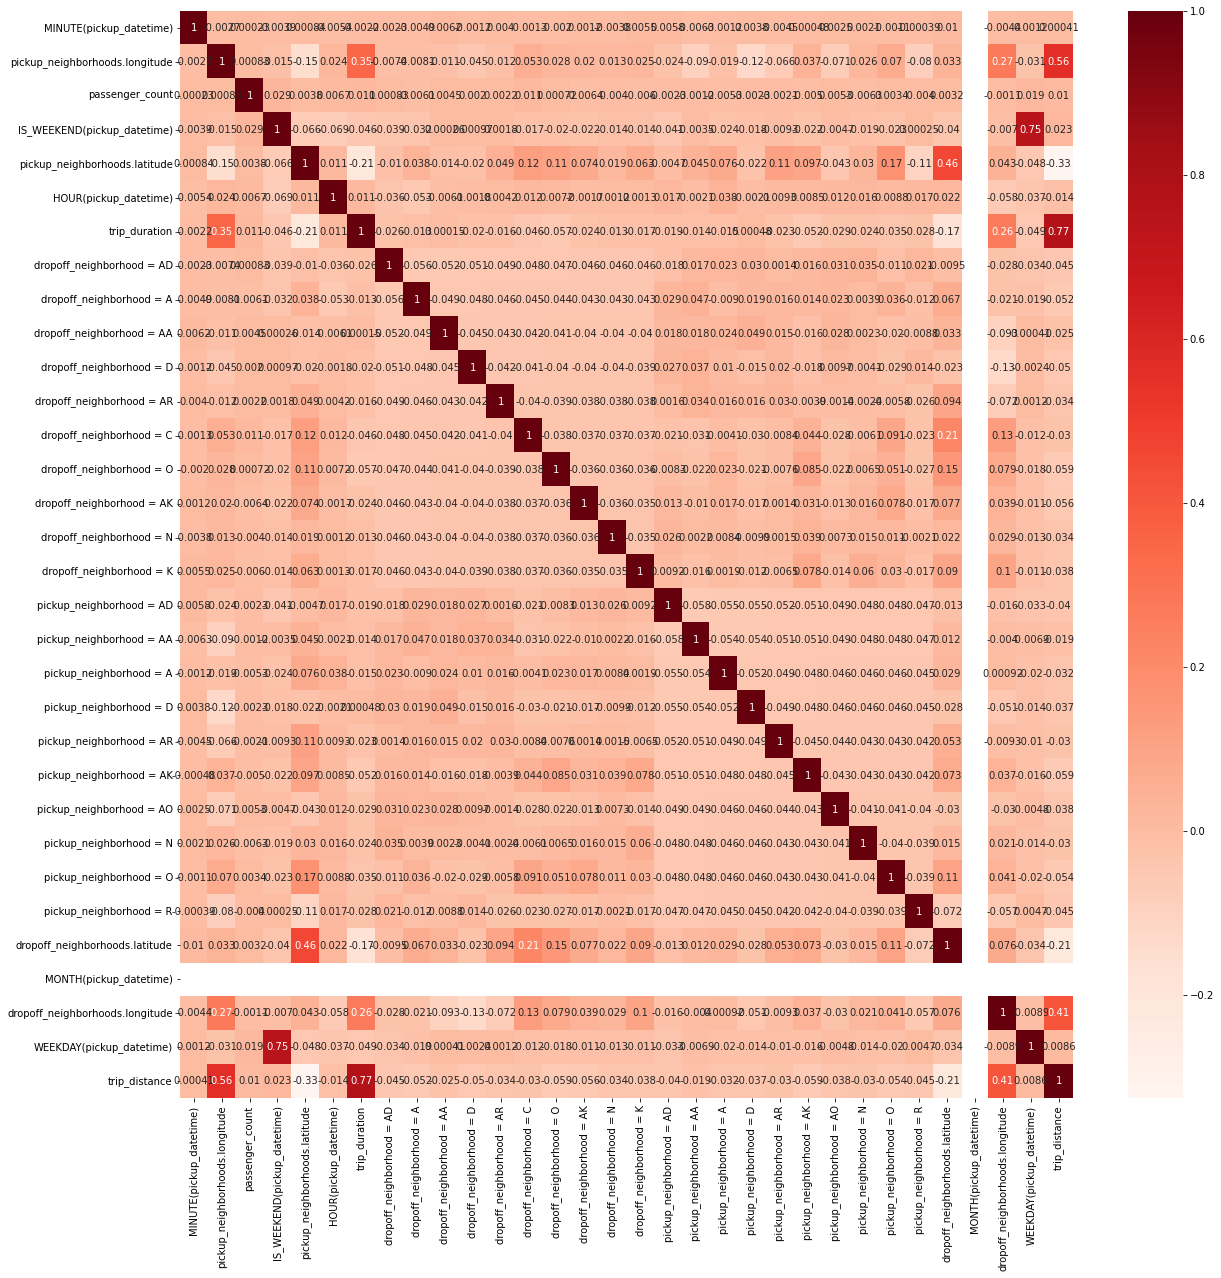

In [86]:
#Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = feature_matrix2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

- The trip distance is the feature with higher statistical significance on the trip duration, which has a positive correlation with the trip duration (around 0.77).
- Eventhough, other parameters like pickup_neighborhood.longitude and dropoff_neighborhood.longitude have a greater correlation, the second most important feature is given by the hour of the pickup date, followed by the dropoff neighborhood latitude, the weekday and wheter it's on the weekend. 
- It makes sense that the latitude is an important feature, since as previously stated, the latitude is fairly more widespread and skewed than the longitude and it could correspond to the airport-hotel area commuting. 
- Therefore, the information about the dropoff neighborhood latitude, hour, and day most common would help the drivers to take a decision to define routes and work schedule. Such relationships can be obtained from the aggregate primitives. 
